# Определение температуры сплава

Для отпимизации производственных расходов на металлургическом комбинате необходимо построить модель, которая предскажет температуру расплавленного состояния сплава на этапе обработки (легирования) стали.

Цикл обработки следующий: расплавленную сталь заливают в ковш, измеряют ее температуру и производят химический анализ. Потом графитовыми электродами, которые установлены в крышке ковша, температуру повышают, добавляют легирующие материалы (сыпучие и проволоку) и продувают сплав инертным газом. Затем сплав перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#EDA-и-первичная-предобработка" data-toc-modified-id="EDA-и-первичная-предобработка-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>EDA и первичная предобработка</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

### EDA и первичная предобработка

In [4]:
# данные об электродах
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')

In [5]:
data_arc.head(6)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043


In [6]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [7]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [8]:
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


В данных об электродах пропусков нет, тип соответствует данным. Есть подозрительное значение реактивной мощности, но так как оно одно - удалим его.

In [9]:
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]

In [10]:
data_arc[data_arc['key'] == 2116]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


In [13]:
# данные о подаче сыпучих материалов (объём)
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')

In [14]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [15]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [16]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Пропуски в данных о подаче сыпучих материалов означают, что данные материалы не добавлялись в конкретный номер партии. Их можно заменить на 0.

In [17]:
data_bulk = data_bulk.fillna(0)

In [21]:
# данные о подаче сыпучих материалов (время)
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')

In [22]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [23]:
# данные о продувке сплава газом
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')

In [24]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [25]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [26]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Данные о продувке сплава газом выглядят адекватно

In [27]:
# результаты измерения температуры
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')

In [28]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [29]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [30]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [31]:
data_temp[data_temp['Температура'] < 1450]

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


Есть несколько неоднозначных значений с температурой ниже теммпературы плавления стали. Возможно это просто ошибка или данные другого металла. Таких значений мало, можно будет их удалить.

In [32]:
data_temp[data_temp['Температура'].isna() == True]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


С 6 августа датчик температуры перестал передавать значения, то есть начиная с 2500 номера партии у нас нет данных о температуре. Все эти данные необходимо удалить.

In [34]:
# данные о проволочных материалах (объём)
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')

In [35]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [37]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [38]:
# аналогично данным о сыпучих материалах, заменим пропуски на 0
data_wire = data_wire.fillna(0)

In [40]:
# данные о проволочных материалах (время)
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [41]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


### Подготовка данных

* удалим все данные с номером партии >= 2500, так как для этих партий нет целевых значений 
* удалим промежуточные измерения температуры
* проверим время измерения температуры: было ли оно после того как добавили легирующие материалы
* в data_temp добавим столбцы с данными о количестве легирующих материалов и о мощности на электродах

In [43]:
# удалим все данные с номером партии >= 2500, так как для этих партий нет целевых значений
# def del_temp(data_):
#     '''
#     функция для удаления всех строк со значением >= 2500
#     '''
#     new_data = data_[data_['key'] < 2500]
#     return new_data

data_arc = data_arc[data_arc['key'] < 2500]
data_bulk = data_bulk[data_bulk['key'] < 2500]
data_bulk_time = data_bulk_time[data_bulk_time['key'] < 2500]
data_gas = data_gas[data_gas['key'] < 2500]
data_temp = data_temp[data_temp['key'] < 2500]
data_wire = data_wire[data_wire['key'] < 2500]
data_wire_time = data_wire_time[data_wire_time['key'] < 2500]

# удалим значения температуры менее температуры плавления стали
data_temp = data_temp[data_temp['Температура'] > 1450]

In [44]:
data_temp_start = pd.DataFrame()
data_temp_start = data_temp.drop_duplicates(subset='key', keep='first')
data_temp_start['Начальная температура'] = data_temp_start['Температура']

/tmp/ipykernel_229/2534164955.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp_start['Начальная температура'] = data_temp_start['Температура']


In [45]:
data_temp_start.head()

,key,Время замера,Температура,Начальная температура
0,1,2019-05-03 11:16:18,1571.0,1571.0
5,2,2019-05-03 11:37:27,1581.0,1581.0
11,3,2019-05-03 12:13:17,1596.0,1596.0
16,4,2019-05-03 12:52:57,1601.0,1601.0
19,5,2019-05-03 13:23:19,1576.0,1576.0


In [46]:
# удалим промежуточные измерения температуры и оставим целевое значение
data_temp = data_temp.drop_duplicates(subset='key', keep='last')

In [62]:
data_temp.head(2)

,key,Время замера,Температура
4,1,2019-05-03 11:30:39,1613.0
10,2,2019-05-03 11:59:12,1602.0


In [47]:
# проверим время измерения температуры: было ли оно после того как добавили легирующие материалы
alloying_materials = pd.DataFrame()
alloying_materials = data_temp.merge(data_wire_time, how='left', on='key')
alloying_materials = alloying_materials.merge(data_bulk_time, how='left', on='key')
alloying_materials = alloying_materials.drop(columns='Температура')

# преобразуем в datetimes
for col in alloying_materials.columns[1:]:
    alloying_materials[col] = pd.to_datetime(alloying_materials[col])
# создадим столбец с последней датой
alloying_materials['last'] = alloying_materials[alloying_materials.columns[1:]].max(axis=1)

# оставим только те значения, где время замера температуры было последним
alloying_materials = alloying_materials[alloying_materials['Время замера'] == alloying_materials['last']]

In [48]:
alloying_materials.head()

,key,Время замера,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,last
0,1,2019-05-03 11:30:39,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:30:39
1,2,2019-05-03 11:59:12,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:59:12
2,3,2019-05-03 12:34:57,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:34:57
3,4,2019-05-03 12:59:25,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:59:25
4,5,2019-05-03 13:36:01,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:36:01


In [49]:
data_arc['Полная мощность'] = ((data_arc['Активная мощность'] ** 2) + (data_arc['Реактивная мощность'] ** 2)) ** 0.5
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239


In [50]:
# найдем сумму полной мощности для каждой партии
power = pd.pivot_table(data_arc, values='Полная мощность', index='key', aggfunc='sum').reset_index()
power.head()

,key,Полная мощность
0,1,5.826395
1,2,3.649216
2,3,2.989534
3,4,3.814962
4,5,4.035758


In [51]:
# найдем сумму активной мощности для каждой партии
active_power = pd.pivot_table(data_arc, values='Активная мощность', index='key', aggfunc='sum').reset_index()
active_power.head()

,key,Активная мощность
0,1,4.878147
1,2,3.052598
2,3,2.525882
3,4,3.209250
4,5,3.347173


In [52]:
# посчитаем время работы электродов в минутах
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])
data_arc['time'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.total_seconds()/60
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,3.800000
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,3.083333
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,2.866667
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,6.083333
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,2.466667


In [53]:
time = pd.pivot_table(data_arc, values='time', index='key', aggfunc='sum').reset_index()
time.head()

,key,time
0,1,18.300000
1,2,13.516667
2,3,10.916667
3,4,12.350000
4,5,14.483333


In [54]:
# отображение всех столбцов
pd.set_option('display.max_columns', None)

In [55]:
# объединим все признаки
data = pd.DataFrame()
data = alloying_materials[['key']].merge(data_temp[['key', 'Температура']], how='inner', on='key')
#data = data.merge(power, how='inner', on='key')
data = data.merge(active_power, how='inner', on='key')
data = data.merge(data_temp_start[['key', 'Начальная температура']], how='inner', on='key')
data = data.merge(data_bulk, how='inner', on='key')
data = data.merge(data_gas, how='inner', on='key')
data = data.merge(data_wire, how='inner', on='key')
#data = data.merge(time, how='inner', on='key')
data = data.set_index('key')
data 

,Температура,Активная мощность,Начальная температура,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1613.0,4.878147,1571.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1602.0,3.052598,1581.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1599.0,2.525882,1596.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1625.0,3.209250,1601.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1602.0,3.347173,1576.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1591.0,3.210690,1570.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,1591.0,4.203064,1554.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,1589.0,2.212379,1571.0,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
data.isna().sum()

Температура              0
Активная мощность        0
Начальная температура    0
Bulk 1                   0
Bulk 2                   0
Bulk 3                   0
Bulk 4                   0
Bulk 5                   0
Bulk 6                   0
Bulk 7                   0
Bulk 8                   0
Bulk 9                   0
Bulk 10                  0
Bulk 11                  0
Bulk 12                  0
Bulk 13                  0
Bulk 14                  0
Bulk 15                  0
Газ 1                    0
Wire 1                   0
Wire 2                   0
Wire 3                   0
Wire 4                   0
Wire 5                   0
Wire 6                   0
Wire 7                   0
Wire 8                   0
Wire 9                   0
dtype: int64

/tmp/ipykernel_229/2232847990.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


<AxesSubplot:>

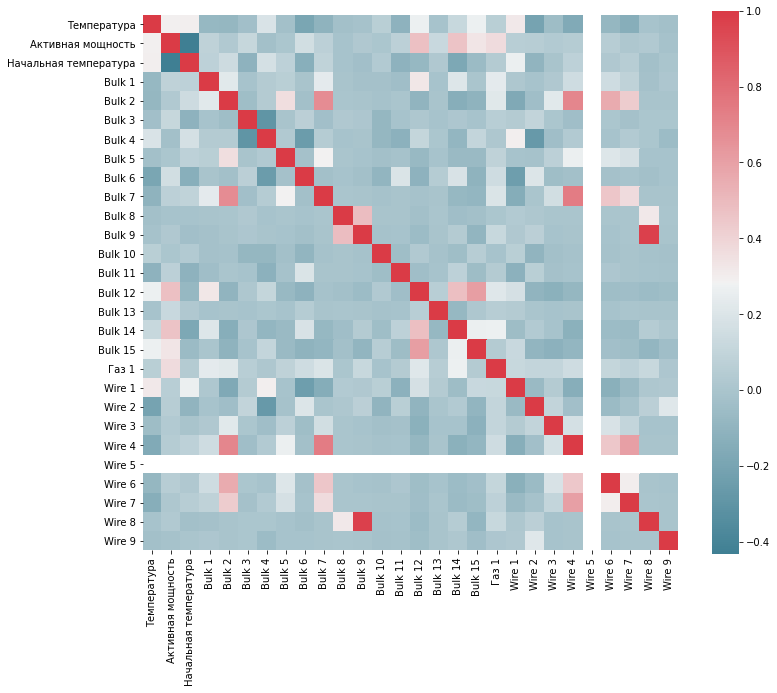

In [57]:
f, ax = plt.subplots(figsize=(12, 10))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [58]:
data.corr()

,Температура,Активная мощность,Начальная температура,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
Температура,1.000000,0.293806,0.298612,-0.075354,-0.082664,-0.034158,0.189282,-0.028404,-0.191146,-0.107556,-0.026655,-0.016101,0.062583,-0.113840,0.270311,-0.010931,0.117569,0.269262,0.061854,0.316793,-0.208231,-0.047639,-0.160145,NaN,-0.084239,-0.137634,-0.010778,-0.027541
Активная мощность,0.293806,1.000000,-0.433712,0.084372,0.031044,0.111473,-0.030115,0.006352,0.157957,0.074487,-0.011457,0.023679,0.005066,0.071440,0.476565,0.122605,0.463989,0.332029,0.371710,0.053568,0.053127,0.035540,0.047644,NaN,0.053287,0.019644,0.029450,-0.016333
Начальная температура,0.298612,-0.433712,1.000000,0.079128,0.141833,-0.111877,0.165827,0.078845,-0.133930,0.087940,-0.011781,-0.033513,0.035484,-0.109883,-0.079544,0.020241,-0.180681,-0.062320,0.039536,0.261887,-0.100001,-0.003478,0.076266,NaN,0.020716,0.052917,-0.029941,0.002592
Bulk 1,-0.075354,0.084372,0.079128,1.000000,0.224657,-0.011651,0.041871,0.060314,-0.002983,0.237180,-0.005748,-0.019835,-0.022956,-0.037875,0.326198,-0.010361,0.207483,-0.001584,0.234078,0.014358,-0.009224,0.020150,0.146255,NaN,0.148466,0.083423,-0.019614,0.010970
Bulk 2,-0.082664,0.031044,0.141833,0.224657,1.000000,-0.046951,0.040833,0.360282,-0.030084,0.679350,-0.001551,-0.005354,-0.018015,0.001496,-0.099426,-0.005614,-0.141704,-0.106233,0.217660,-0.169520,-0.039098,0.223177,0.699337,NaN,0.558876,0.431733,-0.005294,-0.006869
Bulk 3,-0.034158,0.111473,-0.111877,-0.011651,-0.046951,1.000000,-0.294918,-0.006813,0.065556,-0.033525,0.020851,0.011350,-0.084355,-0.009117,0.017928,-0.013408,0.010026,-0.013513,0.058202,0.040761,0.094974,0.005785,-0.040581,NaN,0.007119,-0.019474,0.004851,0.004625
Bulk 4,0.189282,-0.030115,0.165827,0.041871,0.040833,-0.294918,1.000000,0.028369,-0.251738,0.045941,-0.013205,-0.002952,-0.083911,-0.119209,0.107605,0.003204,-0.090638,0.103143,0.018288,0.298083,-0.267981,-0.039281,0.034456,NaN,-0.011444,0.033866,0.007832,-0.058221
Bulk 5,-0.028404,0.006352,0.078845,0.060314,0.360282,-0.006813,0.028369,1.000000,-0.021769,0.288318,-0.002453,-0.008464,-0.028481,-0.015830,-0.073238,-0.008876,-0.066538,-0.067734,0.086840,-0.013231,-0.013803,0.070867,0.262743,NaN,0.204778,0.172132,-0.008370,-0.010859
Bulk 6,-0.191146,0.157957,-0.133930,-0.002983,-0.030084,0.065556,-0.251738,-0.021769,1.000000,-0.025176,-0.008362,-0.028858,-0.097104,0.196931,-0.109840,0.043221,0.184734,-0.106108,0.145040,-0.241284,0.203525,-0.046674,-0.026002,NaN,-0.020137,-0.012478,-0.028536,-0.013235
Bulk 7,-0.107556,0.074487,0.087940,0.237180,0.679350,-0.033525,0.045941,0.288318,-0.025176,1.000000,-0.001360,-0.004693,-0.015793,-0.004901,-0.017939,-0.004922,-0.076884,-0.090565,0.198539,-0.143297,-0.000628,0.156602,0.740568,NaN,0.456087,0.372246,-0.004641,-0.006021


Высокая коллинеарность у признаков Wire 8 и Bulk 9, один из них нужно удалить. В Wire 5 нет никакой информации, тоже следует удалить.

In [59]:
# # Удаление неиформативных столбцов, у которых 95% одинаковые значения - метод подходит только для модели LGBMRegressor
max_value = data.shape[0] * 0.95
for col in data.columns:
    value = data[col].value_counts().index[0]
    if data[col].value_counts()[value] >= max_value:
        print(col)
        data = data.drop(columns=col)

Bulk 2
Bulk 5
Bulk 7
Bulk 8
Bulk 9
Bulk 13
Wire 3
Wire 4
Wire 5
Wire 6
Wire 7
Wire 8
Wire 9


In [60]:
#data = data.drop(columns=['Bulk 9', 'Wire 5'])

In [61]:
data

,Температура,Активная мощность,Начальная температура,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Газ 1,Wire 1,Wire 2
key,,,,,,,,,,,,,,,
1,1613.0,4.878147,1571.0,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,29.749986,60.059998,0.00000
2,1602.0,3.052598,1581.0,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,12.555561,96.052315,0.00000
3,1599.0,2.525882,1596.0,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,28.554793,91.160157,0.00000
4,1625.0,3.209250,1601.0,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,18.841219,89.063515,0.00000
5,1602.0,3.347173,1576.0,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,5.413692,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1591.0,3.210690,1570.0,0.0,21.0,0.0,0.0,90.0,0.0,256.0,129.0,223.0,7.125735,89.150879,0.00000
2496,1591.0,4.203064,1554.0,0.0,0.0,63.0,0.0,122.0,0.0,256.0,129.0,226.0,9.412616,114.179527,0.00000
2497,1589.0,2.212379,1571.0,0.0,0.0,85.0,0.0,0.0,0.0,230.0,124.0,226.0,6.271699,94.086723,9.04800


## Обучение моделей

* разделим данные на тренировочную и тестовую выборки
* обучим несколько моделей, подберем лучше параметры

In [63]:
target = data['Температура']
features = data.drop('Температура', axis=1)
feature_list = list(features.columns)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [64]:
model = LinearRegression()
scores = cross_val_score(model, features_train, target_train, cv=5, scoring='neg_mean_absolute_error')
print('Значение MAE для линейной регрессии: {} '.format(-scores.mean()))

Значение MAE для линейной регрессии: 6.179473123576644 


In [67]:
model = RandomForestRegressor(random_state=12345)
param_grid = {'max_depth': range(4, 16, 2), 'n_estimators': [10, 50, 100, 200]}
search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error')
search.fit(features_train, target_train)
print('Лучшее значение MAE для случайного леса: {} при значениях гиперпараметров: {}'.format(-search.best_score_, search.best_params_))

Лучшее значение MAE для случайного леса: 5.982686790642172 при значениях гиперпараметров: {'max_depth': 10, 'n_estimators': 200}


In [66]:
model_lgb = LGBMRegressor()
param_lgb = {'max_depth': range(4, 16, 2), 'n_estimators': [10, 50, 100, 200]}
lgb_grid = GridSearchCV(model_lgb, param_lgb, cv=3, scoring='neg_mean_absolute_error')
lgb_grid.fit(features_train, target_train)
print('Лучшее значение MAE для LGBMRegressor: {} при значениях гиперпараметров: {}'.format(-lgb_grid.best_score_, lgb_grid.best_params_))

Лучшее значение MAE для LGBMRegressor: 5.927120376393482 при значениях гиперпараметров: {'max_depth': 4, 'n_estimators': 50}


In [72]:
cbr = CatBoostRegressor()
 
cbr_params = {'learning_rate': [0.01, 0.1],
             'depth': [5, 8, 10, 12]}  
 
cbr_grid = GridSearchCV(cbr, cbr_params, cv=3, scoring='neg_mean_absolute_error')
cbr_grid.fit(features_train, target_train)

print('Лучшее значение MAE для CatBoostRegressor: {} при значениях гиперпараметров: {}'.format(-cbr_grid.best_score_, cbr_grid.best_params_))

0:	learn: 11.0696694	total: 3.77ms	remaining: 3.77s
1:	learn: 11.0473462	total: 8.7ms	remaining: 4.34s
2:	learn: 11.0144437	total: 11.9ms	remaining: 3.95s
3:	learn: 10.9910034	total: 15.2ms	remaining: 3.79s
4:	learn: 10.9635339	total: 18.6ms	remaining: 3.71s
5:	learn: 10.9350416	total: 21.9ms	remaining: 3.62s
6:	learn: 10.9095411	total: 25.2ms	remaining: 3.57s
7:	learn: 10.8783673	total: 28.7ms	remaining: 3.56s
8:	learn: 10.8472679	total: 32ms	remaining: 3.53s
9:	learn: 10.8231490	total: 35.3ms	remaining: 3.5s
10:	learn: 10.7928274	total: 39.3ms	remaining: 3.53s
11:	learn: 10.7624520	total: 45.6ms	remaining: 3.75s
12:	learn: 10.7399346	total: 49.5ms	remaining: 3.76s
13:	learn: 10.7127258	total: 53.8ms	remaining: 3.79s
14:	learn: 10.6879395	total: 58.1ms	remaining: 3.81s
15:	learn: 10.6686439	total: 64.4ms	remaining: 3.96s
16:	learn: 10.6413120	total: 69.6ms	remaining: 4.02s
17:	learn: 10.6124025	total: 73.9ms	remaining: 4.03s
18:	learn: 10.5850323	total: 77.1ms	remaining: 3.98s
19:	lea

## Анализ моделей

* проверим модель на тестовой выборке
* сделаем выводы

In [65]:
%%time
model_RFR = RandomForestRegressor(max_depth=10, n_estimators=200, random_state=12345)
model_RFR.fit(features_train, target_train)
predictions = model_RFR.predict(features_test)
print(mae(target_test, predictions))

6.271566738303216
CPU times: user 1.38 s, sys: 2.45 ms, total: 1.38 s
Wall time: 1.38 s


In [66]:
%%time
model_lgb = LGBMRegressor(learning_rate=0.01, max_depth=8, n_estimators=300, random_state=12345)
model_lgb.fit(features_train, target_train)
predictions = model_lgb.predict(features_test)
print(mae(target_test, predictions))

6.155376392737187
CPU times: user 3.15 s, sys: 0 ns, total: 3.15 s
Wall time: 3.06 s


In [67]:
%%time
model_lgb = LGBMRegressor(max_depth=4, n_estimators=50, random_state=12345)
model_lgb.fit(features_train, target_train)
predictions = model_lgb.predict(features_test)
print(mae(target_test, predictions))

6.280147400182572
CPU times: user 239 ms, sys: 0 ns, total: 239 ms
Wall time: 125 ms


In [68]:
importances = list(model_lgb.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:22} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Начальная температура  Importance: 140
Variable: Активная мощность      Importance: 121
Variable: Bulk 14                Importance: 49
Variable: Wire 1                 Importance: 46
Variable: Газ 1                  Importance: 41
Variable: Bulk 1                 Importance: 28
Variable: Wire 2                 Importance: 28
Variable: Bulk 6                 Importance: 27
Variable: Bulk 3                 Importance: 17
Variable: Bulk 15                Importance: 15
Variable: Bulk 12                Importance: 14
Variable: Bulk 4                 Importance: 11
Variable: Bulk 11                Importance: 4
Variable: Bulk 10                Importance: 0


## Вывод

Лучшее значение MAE = 6.16 градусов у модели LGBMRegressor с гиперпараметрами learning_rate=0.01, max_depth=8, n_estimators=300, но самая быстрая модель LGBMRegressor с параметрами max_depth=4, n_estimators=50 имеет значение MAE = 6.28 градусов, при этом разница в метрике 0.12 градуса не имеет большого значения, поэтому следует выбрать последнюю. 

Анализ важности факторов показал, что большее влияние имеет начальная температура и активная мощность (или же время) при нагреве сплава электродами. Таким образом, на эти факторы необходимо обратить внимание для уменьшения потребления электроэнергии на этапе обработки стали.